# Support Vector Regression

In [28]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cvx

from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error as mse 

In [29]:
#Generate sample data
X = np.sort(10*np.random.rand(100,1),axis=0)
'''
np.random.rand: 
Create an array of the given shape and 
populate it with random samples from a uniform distribution over [0, 1).
'''
y = np.sin(X).ravel()
y[::5] += 2*(0.5-np.random.rand(20))
y[::4] += 3*(0.5-np.random.rand(25))
y[::1] += 1*(0.5-np.random.rand(100))

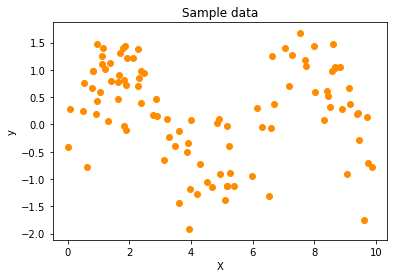

In [30]:
#visualize sample data
plt.scatter(X, y, color='darkorange', label='data')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Sample data')
plt.show()

## basic SVR model

### loss function
![loss](./img/svr1.png)

![rbf](./img/rbf_kernel.png)

In [31]:
#kernel functions
def rbf_kernel(x1,x2,gamma=0.1):
    return np.exp(-gamma*np.linalg.norm(x1-x2)**2)

#gram matrix
def kernel_mat(X,kernel=None,coef0=0.0,degree=3,gamma=0.1):
    X = np.array(X,dtype=np.float64)
    mat = []
    for i in X:
        row = []
        for j in X:
            if kernel=='poly':
                row.append(polynomial_kernel(i,j,coef0,degree,gamma))
            elif kernel=='linear':
                row.append(linear_kernel(i,j,coef0))
            elif kernel=='rbf':
                row.append(rbf_kernel(i,j,gamma))
            else:
                row.append(np.dot(i,j))
        mat.append(row)
    return mat

![dual](./img/svr4.png)

In [32]:
C = 1
epsilon = 1.0

n = X.shape[0]

#variable for dual optimization problem
alpha = cvx.Variable(n)
alpha_ = cvx.Variable(n)

one_vec = np.ones(n)

![const](./img/constraints.png)


In [33]:
#constraints
constraints = []
constraints += [cvx.sum_entries(one_vec*alpha-one_vec*alpha_)==0]
for i in range(n):
    constraints += [alpha[i] >= 0, alpha_[i] >=0, alpha[i] <= C, alpha_[i] <= C]

![objective](./img/objective.png)

![q](./img/quad.png)

![q2](./img/quad2.png)

In [34]:
#objective function
obj = -.5*cvx.quad_form(alpha-alpha_,kernel_mat(X,kernel='rbf',gamma=0.1))
obj = obj - epsilon*one_vec*(alpha+alpha_) + y*(alpha-alpha_)

svr_obj = cvx.Maximize(obj)
svr = cvx.Problem(svr_obj,constraints)
svr.solve()

3.9217411813120266

### support vector => compute b
![support](./img/support_vector.png)

In [35]:
#Compute b
idx = np.where((np.array(alpha.value).ravel() < C-1E-7) * (np.array(alpha.value).ravel() > 1E-7))[0][0]
b = -epsilon + y[idx] - np.sum([(alpha.value[i]-alpha_.value[i])*rbf_kernel(X[idx], X[i]) for i in range(n)])
print(b)

-0.0512647295334


In [36]:
#predict 
results = []
for j in range(n):
    new_X = X[j]
    results += [np.sum([(alpha.value[i] - alpha_.value[i]) *rbf_kernel(new_X, X[i]) for i in range(n)]) + b]


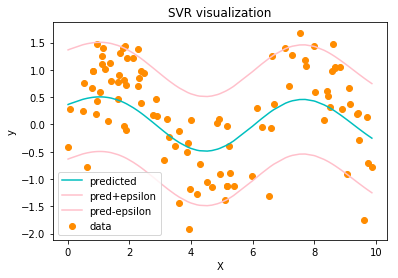

In [37]:
#visualization    
plt.scatter(X, y, color='darkorange', label='data')
plt.plot(X, results, color='c', label='predicted')
plt.plot(X,results+one_vec*1.0,color='pink', label='pred+epsilon')
plt.plot(X,results-one_vec*1.0,color='pink', label='pred-epsilon')
plt.xlabel('X')
plt.ylabel('y')
plt.title('SVR visualization')
plt.legend()
plt.show()

### compare to sklearn package

b: -0.051265  package b: -0.050773


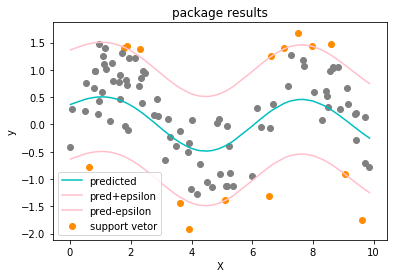

In [38]:
svr = SVR(kernel='rbf',C=1.0,epsilon=1,gamma=0.1)
svr.fit(X,y)

print('b: %f  package b: %f'%(b,svr.intercept_))

not_support_ = [i for i in range(len(X)) if i not in svr.support_]

pred = svr.predict(X)
plt.scatter(X[svr.support_], y[svr.support_], color='darkorange', label='support vetor')
plt.scatter(X[not_support_],y[not_support_], color='gray')
plt.plot(X, pred, color='c', label='predicted')
plt.plot(X,pred+epsilon*one_vec,color='pink', label='pred+epsilon')
plt.plot(X,pred-epsilon*one_vec,color='pink', label='pred-epsilon')
plt.xlabel('X')
plt.ylabel('y')
plt.title('package results')
plt.legend()
plt.show()    

In [39]:
print(mse(pred,results))
print(mse(y,results))
print(mse(y,pred))

4.95054738115e-07
0.442739799
0.442738502573
